In [1]:
library(ggplot2)
library(readxl)
library(tidyr)
library(forcats)
library(jsonlite)
library(stringr)
library(tidyverse)

Loading tidyverse: tibble
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


The first thing to do is to import the JSON data from the survey system.  There is some nontrivial munging for which Rich Salaay has the script.  Here, I assume that we get JSON from Rich, and that the data is further hand-cleaned to take care of missing system labels on questions.

The key point is to arrange things into a data frame, where the column "header" is actually a question from the survey, and "value" is the answer to that question.  The questions in the survey form include responses to the per-task, post-task, and SUS, as well as 'SCORE' which is the manual assessment of participant task success.

In [21]:
?fct_relevel

In [23]:
jsontext <- readLines("CHT_Participant_Survey_Data_7_28.json")
jsons <- lapply(jsontext, fromJSON)
df <- as.data.frame(do.call(rbind, tail(jsons, -1)))
names(df) <- c("participant", "question", "system", "header", "value")
df <- df %>% mutate(question = fct_relevel(question, "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "DEMO", "TOOL ASSESSMENT 1", "TOOL ASSESSMENT 2", "OVERALL ASSESSMENT"))
summary(df)

  participant      question           system    
 28     : 530   DEMO   : 462   DIG       :1284  
 13     : 281   1      : 230   N/A       : 539  
 3      : 281   2      : 168   Tellfinder:1296  
 14     : 269   4      : 156                    
 11     : 247   6      : 144                    
 12     : 247   8      : 144                    
 (Other):1264   (Other):1815                    
                                                                                                       header    
 SCORE                                                                                                    : 193  
 Do you feel that this question was operationally relevant or useful in your investigative search process?: 191  
 Please list any comments about the question or workflow.                                                 : 191  
 Post-task Questionnaire                                                                                  : 191  
 Tool Usage [I would have to use anoth

# Score #


Here is the absolute top level view: is there a difference in participant score between the two systems? Score is a qualitative judgment of the participant's success at the task:

- 0: the participant gave up or found no information at all
- 1: the participant found some information
- 2: the participant found more information, including some of the ground truth
- 3: the participant found more information, including all of the ground truth

Warning message in evalq(as.integer(as.character(value)), <environment>):
“NAs introduced by coercion”Warning message:
“Removed 11 rows containing non-finite values (stat_count).”

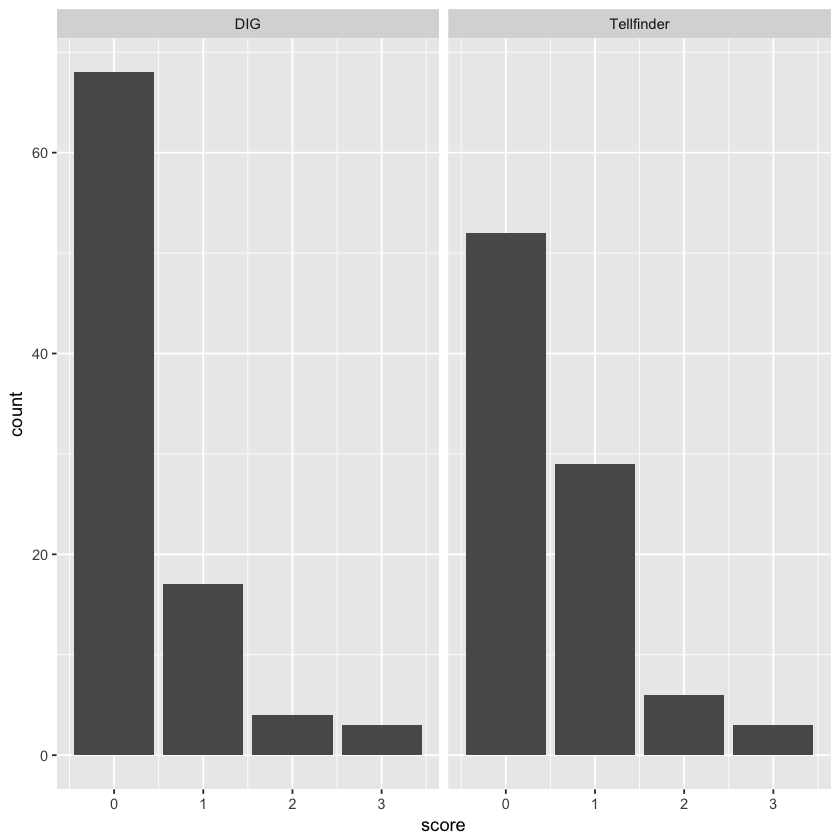

In [24]:
scores <- df %>% 
    filter(header == 'SCORE') %>%
    mutate(score = as.integer(as.character(value)))
ggplot(scores, aes(x = score)) + geom_bar() + facet_wrap(~system)

Is there a problem with the questions?  There are score=0 events for every question, and there are three questions (2, 9, 12) where no participant gets a score higher than 0.

Warning message:
“Removed 11 rows containing non-finite values (stat_sum).”

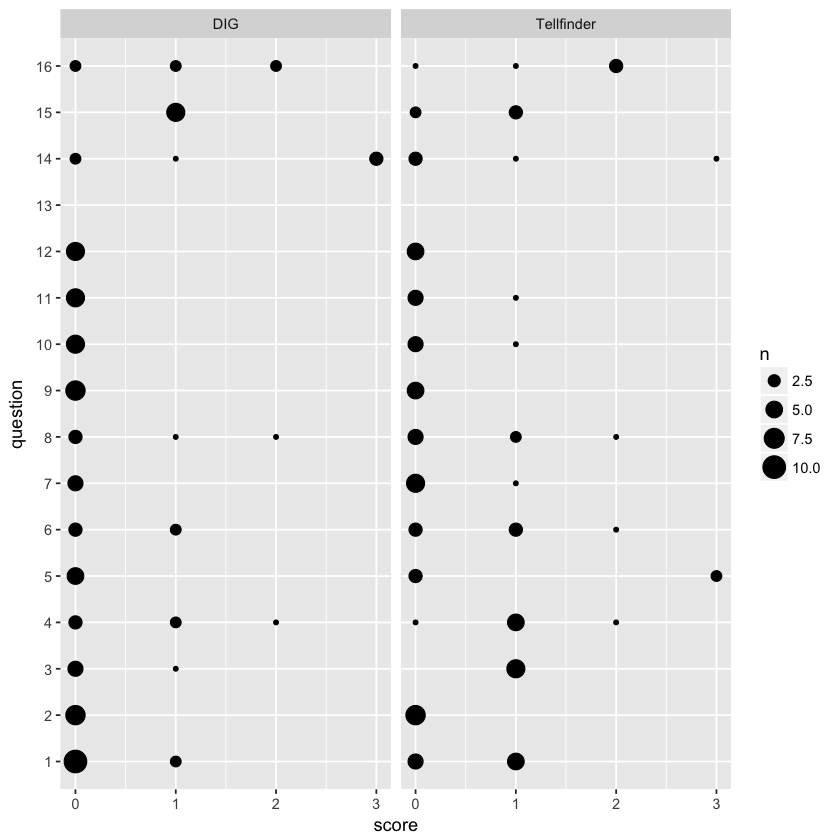

In [25]:
ggplot(scores, aes(score, question)) + geom_count() + facet_grid(~system)

First, let's see if there is an affect from participant's prior experience with the tools.  In order to work with the demographic data, I'm going to recode that part of the table to it easier.

In [5]:
demog <- df %>% filter(question == 'DEMO') %>%
    mutate(header = fct_recode(header, 
        "participant_id" = "Please enter your participant ID number.åÊ",
        "years_analyst" = "How many years of experience do you have as an analyst or investigator?",
        "years_cht" = "How many years of experience do you have specifically in counter-human-trafficking investigations or analysis?",
        "hours_online" = "How many hours per week do you spend online researching information relating to Counter-HT leads?",
        "dig_exp" = "Tell us about your prior experience using the Memex tools. [Do you have prior experience with this tool? (y/n)][DIG]",
        "tf_exp" = "Tell us about your prior experience using the Memex tools. [Do you have prior experience with this tool? (y/n)][Tellfinder]",
        "dig_years" = "Tell us about your prior experience using the Memex tools. [If so, how long is that experience? (\"NA\", \"# of years\")][DIG]",
        "tf_years" = "Tell us about your prior experience using the Memex tools. [If so, how long is that experience? (\"NA\", \"# of years\")][Tellfinder]",
        "dig_rating" = "Rate your expertise with each tool by on a scale of 1(Basic) to 5(Power User). [DIG]",
        "tf_rating" = "Rate your expertise with each tool by on a scale of 1(Basic) to 5(Power User). [Tellfinder]",
        "other_rating" = "Rate your expertise with other tools used by on a scale of 1(Basic) to 5(Power User). [Other Tools Used]"
    )) %>%
    filter(participant != '') %>%
    mutate(value = fct_collapse(value, 
                                 y = c("y", "Y", "Yes", "yes"),
                                 n = c("n", "N", "No", "no")
                                )) %>%
    select(-question, -system) %>%
    distinct(participant, header, .keep_all = TRUE) %>%
    spread(header, value) %>%
    select(participant, contains("_"))

Warning message:
“Unknown levels in `f`: yes”

And then join the demographic data with the scores so we can analyze scores at different levels of participant experience.  The plots below shows participant scores broken down along their self-reported experience with DIG, and then with TellFinder.  There is not a lot of data in each cell, unfortunately, but the tentative hypothesis I would make would be that experience with one system or the other is not predictive of success in the questions as measured by the score.

Joining, by = "participant"
Warning message:
“Removed 11 rows containing non-finite values (stat_sum).”

Warning message:
“Removed 11 rows containing non-finite values (stat_sum).”

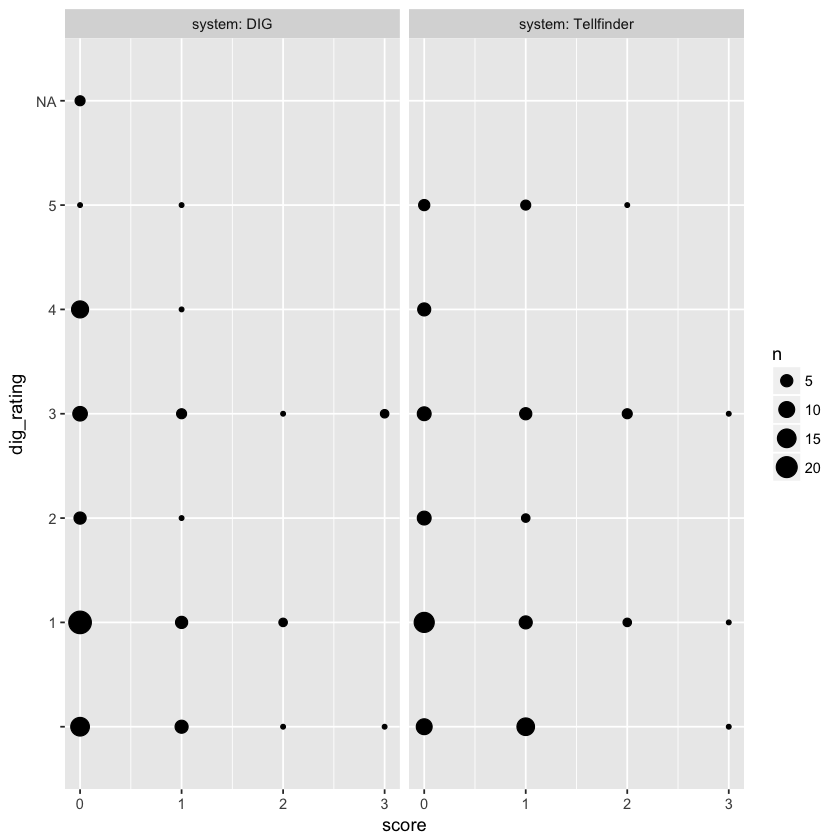

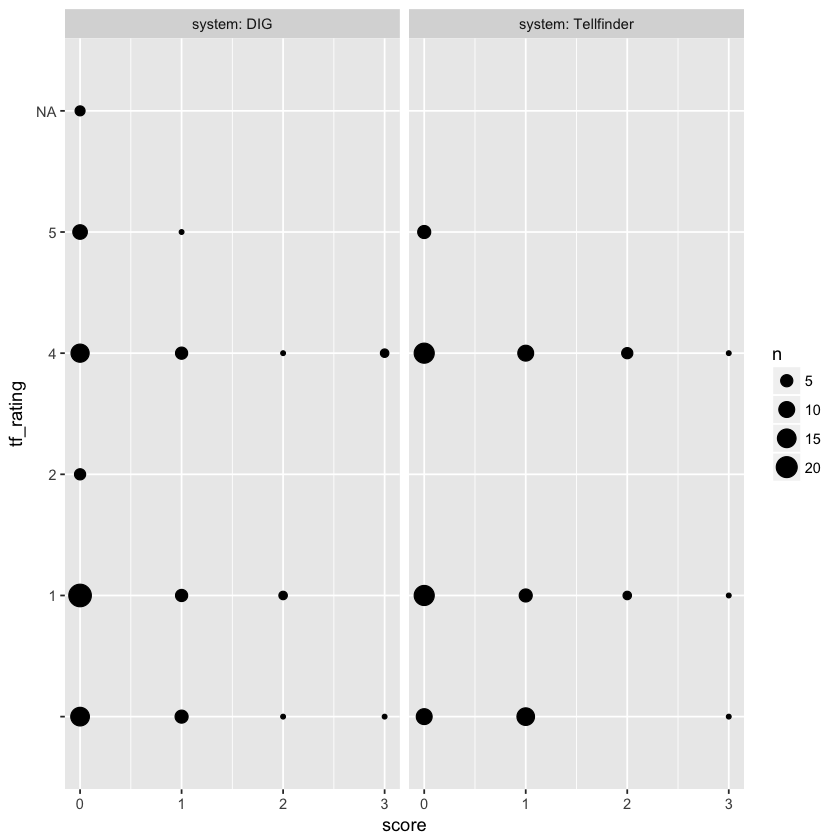

In [19]:
demo_scores <- scores %>% left_join(demog)
ggplot(demo_scores, aes(score, dig_rating)) + geom_count() + facet_wrap(~system, labeller="label_both")
ggplot(demo_scores, aes(score, tf_rating)) + geom_count() + facet_wrap(~system, labeller="label_both")

# Time #

Next, I want to look at the time it takes for participants to complete questions.  I'm going to trim out times longer than 20 minutes, to focus on questions fitting in our notion of the appropriate timeframe.  Times with TellFinder are somewhat shorter but not significantly (judging by boxplot overlap).

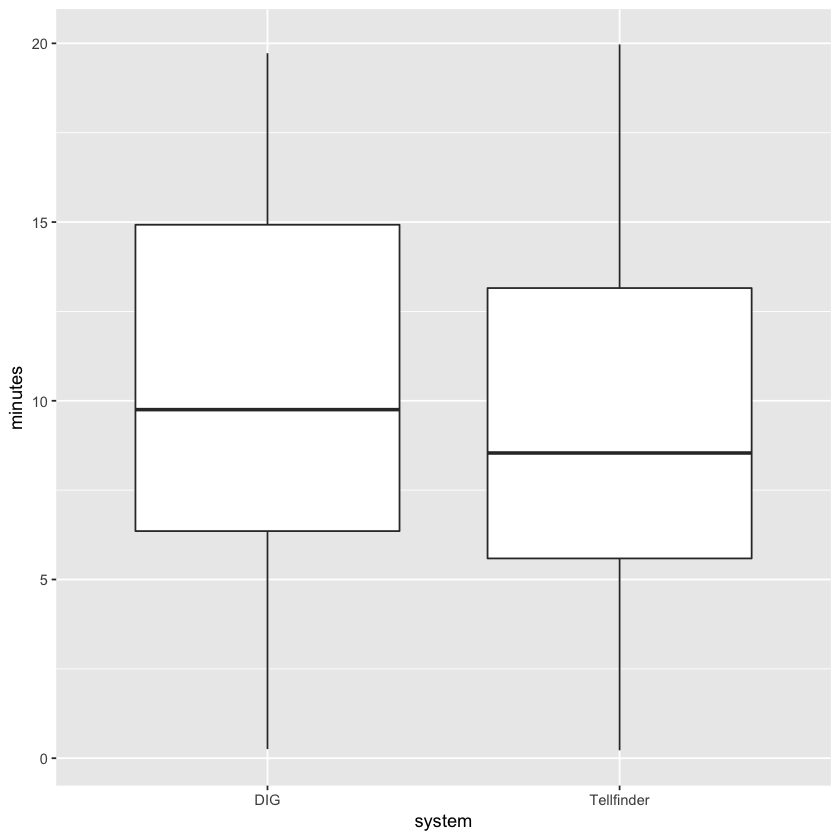

In [7]:
times <- df %>% 
    filter(str_detect(header, "Group time")) %>%
    filter(question != "DEMO") %>%
    mutate(minutes = parse_number(value) / 60.0) %>%
    filter(minutes < 20.0)
ggplot(times, aes(system, minutes)) + geom_boxplot()

However, if we limit our examination to questions that have a score better than 1, we see that DIG has shorter times.  This could mean that DIG is faster for successful questions, or it takes more time with TellFinder to get to the end when the participant won't succeed. 

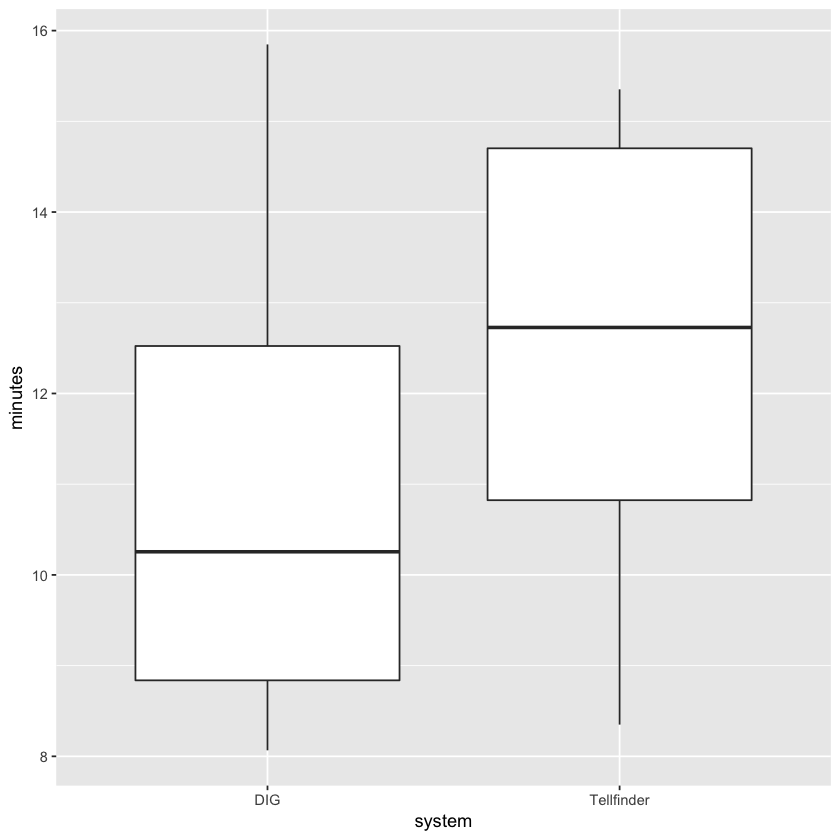

In [8]:
times <- df %>% 
    filter(str_detect(header, "Group time")) %>%
    filter(question != "DEMO") %>%
    group_by(participant, question) %>%
    inner_join(scores, by=c("participant", "question", "system")) %>%
    select(participant, question, system, seconds=value.x, score) %>%
    mutate(minutes = parse_number(seconds) / 60.0, score=parse_number(score)) %>%
    filter(minutes < 20.0, score > 1)
ggplot(times, aes(system, minutes)) + geom_boxplot()

In contrast, the times for questions where the score was 0 is 

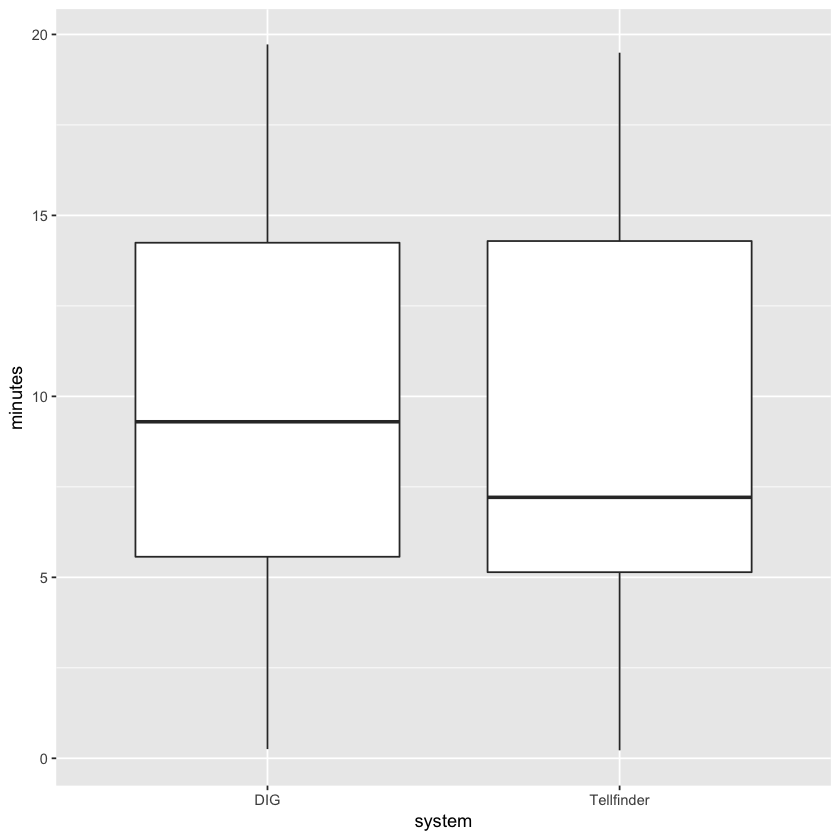

In [29]:
fail_times <- df %>% 
    filter(str_detect(header, "Group time")) %>%
    filter(question != "DEMO") %>%
    group_by(participant, question) %>%
    inner_join(scores, by=c("participant", "question", "system")) %>%
    select(participant, question, system, seconds=value.x, score) %>%
    mutate(minutes = parse_number(seconds) / 60.0, score=parse_number(score)) %>%
    filter(minutes < 20.0, score < 1)
ggplot(fail_times, aes(system, minutes)) + geom_boxplot()

# SUS and Task Questionnaires#

Here are SUS scores.  This code is messy because we have to score the survey results.  In the plot, three colored lines show guideline interpretations from SUS use in generic websites.  The green line corresponds to a SUS of 80.3, which is like getting an "A" in website usability.  68 is a C, 51 is an F.

Rather than following that scoring rubric, which might not be appropriate for systems like these which are quite a bit more complicated than general websites, the relative difference is more informative.

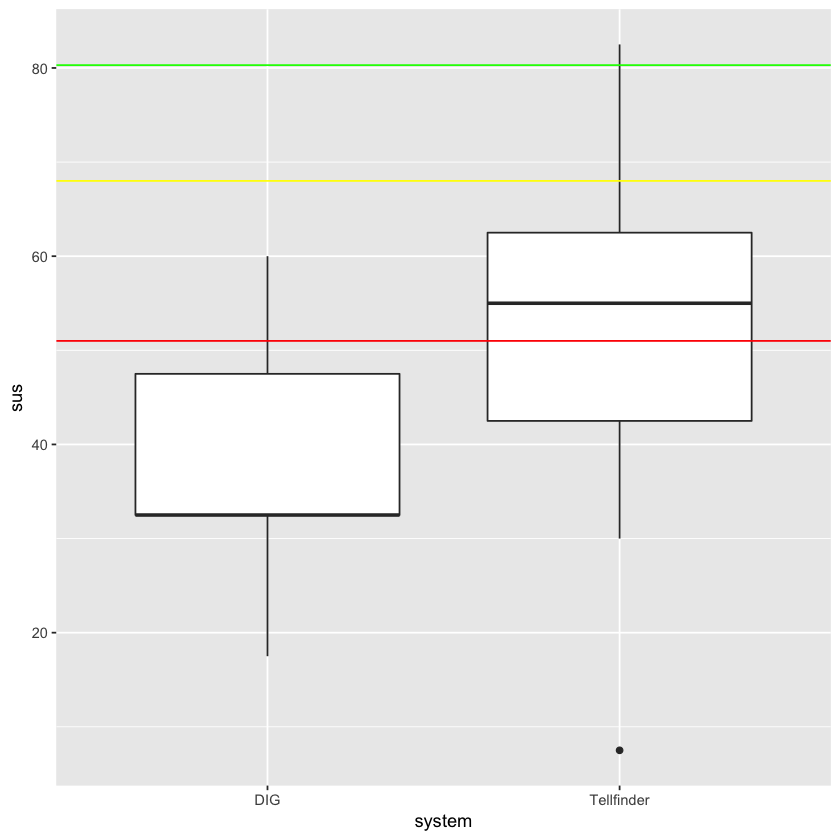

In [9]:
sus <- df %>% filter(str_detect(question, "TOOL ASSESSMENT")) %>%
    mutate(header = fct_recode(header, 
        "q1" = "Instructions: For each of the following statements, mark the\u00e5\u00caone\u00e5\u00cathat best describes your reactions to the system that you just used. [I think that I would like to use this system frequently.]",
        "q2" = "Instructions: For each of the following statements, mark the\u00e5\u00caone\u00e5\u00cathat best describes your reactions to the system that you just used. [I found this system unnecessarily complex.]",
        "q3" = "Instructions: For each of the following statements, mark the\u00e5\u00caone\u00e5\u00cathat best describes your reactions to the system that you just used. [I thought this system was easy to use.]",
        "q4" = "Instructions: For each of the following statements, mark the\u00e5\u00caone\u00e5\u00cathat best describes your reactions to the system that you just used. [I think that I would need assistance to be able to use this system.]",
        "q5" = "Instructions: For each of the following statements, mark the\u00e5\u00caone\u00e5\u00cathat best describes your reactions to the system that you just used. [I found the various functions in this system were well integrated.]",
        "q6" = "Instructions: For each of the following statements, mark the\u00e5\u00caone\u00e5\u00cathat best describes your reactions to the system that you just used. [I thought that there was too much inconsistency in this system.]",
        "q7" = "Instructions: For each of the following statements, mark the\u00e5\u00caone\u00e5\u00cathat best describes your reactions to the system that you just used. [I would imagine that most subject matter experts in my domain would learn to use this system very quickly.]",
        "q8" = "Instructions: For each of the following statements, mark the\u00e5\u00caone\u00e5\u00cathat best describes your reactions to the system that you just used. [I found this system very cumbersome or awkward to use.]",
        "q9" = "Instructions: For each of the following statements, mark the\u00e5\u00caone\u00e5\u00cathat best describes your reactions to the system that you just used. [I felt very confident using this system.]",
        "q10" = "Instructions: For each of the following statements, mark the\u00e5\u00caone\u00e5\u00cathat best describes your reactions to the system that you just used. [I needed to learn a lot of things before I could get going with this system.]",
        NULL = "Tool to be evaluated:",
        NULL = "Instructions: For each of the following statements, mark the\u00e5\u00caone\u00e5\u00cathat best describes your reactions to the system that you just used. []",
        NULL = "Any other comments about the system?"
                              ),
        value = fct_recode(value,
        "1" = "Strongly disagree",
        "2" = "Disagree",
        "3" = "Neither agree nor disagree",
        "4" = "Agree",
        "5" = "Strongly agree",
        "3"  = "")) %>%
    filter(header != "NA")  %>%
    distinct(participant, question , system, header, .keep_all=TRUE) %>%
    spread(header, value) %>%
    mutate(Q1 = parse_number((q1)),
        Q2 = parse_number((q2)),
        Q3 = parse_number((q3)),
        Q4 = parse_number((q4)),
        Q5 = parse_number((q5)),
        Q6 = parse_number((q6)),
        Q7 = parse_number((q7)),
        Q8 = parse_number((q8)),
        Q9 = parse_number((q9)),
        Q10 = parse_number((q10))) %>%
    mutate(sus = 2.5 * ((Q1-1) + (5-Q2) + (Q3-1) + (5-Q4) + (Q5-1) + (5-Q6) + (Q7-1) + (5-Q8) + (Q9-1) + (5-Q10)))
ggplot(sus, aes(system, sus)) + geom_boxplot() + 
    geom_hline(yintercept = 80.3, color="green") + 
    geom_hline(yintercept = 68, color="yellow") + 
    geom_hline(yintercept = 51, color="red")

The post-task questionnaire asked five questions to gauge subjective reactions to the interface in the context of each question.  The questions asked were:

- I would have to use another tool to find answers to this question.
- The generated results were what I expected to display given my search query.
- The process took an acceptable amount of time to answer the question.
- This question would be difficult to search and get good results for no matter what system I used.
- How easy or difficult did the UI make it to enter the parameters of the search?

The primary difference seems to be more "Agree" for TellFinder on the "results were expected" and "time was acceptable" questions.


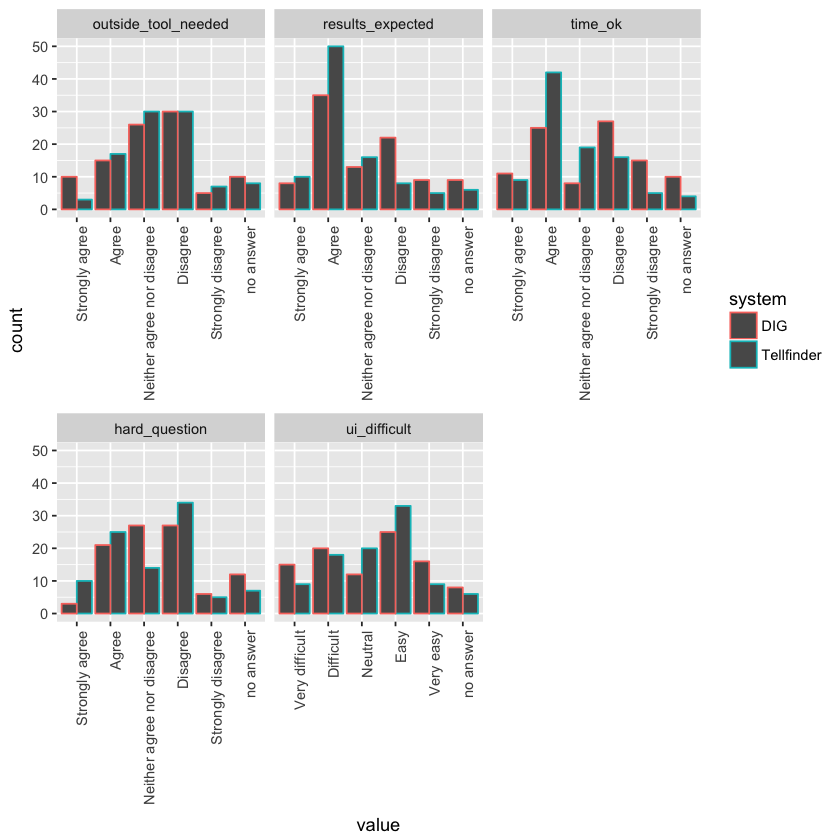

In [10]:
postq <- df %>%
    mutate(header = fct_recode(header,
        ui_difficult = "User Interaction Difficulty [How easy or difficult did the UI make it to enter the parameters of the search?]",
        results_expected = "Tool Usage [The generated results were what I expected to display given my search query.]",
        hard_question = "Tool Usage [This question would be difficult to search and get good results for no matter what system I used.]",
        time_ok = "Tool Usage [The process took an acceptable amount of time to answer the question.]",
        outside_tool_needed = "Tool Usage [I would have to use another tool to find answers to this question.]"
    )) %>%
    mutate(value = fct_recode(value, "no answer" = "")) %>%
    mutate(value = fct_relevel(value, "Strongly agree", "Agree", "Neither agree nor disagree", "Disagree", "Strongly disagree",
                                       "Very difficult", "Difficult", "Neutral", "Easy", "Very easy"
                              )) %>%
    filter(header %in% c("ui_difficult", "results_expected", "hard_question", "time_ok", "outside_tool_needed")) %>%
    group_by(participant, question, system, header)

ggplot(postq) + geom_bar(mapping = aes(x = value, color=system), position="dodge") +
    facet_wrap(~header, scales="free_x") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))
